# Goal
Compare
- `get_time_series_cross_val_splits` from [utils.py](https://github.com/numerai/example-scripts/blob/6b72e4aebbd906d4f727360f4cd0052ef08a97fc/utils.py#L80)
- `PurgedTimeSeriesSplitGroups` from the Forum
- `sklearn.model_selection._split`

In [1]:
from IPython.display import display, HTML, clear_output
display(HTML("<style>.container { width:100% !important; }</style>"))

In [2]:
import json
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

import numerapi

In [3]:
%load_ext autoreload
%autoreload 2

import sys
sys.path.append("..")
# visp's personal model training util functions available at
# https://github.com/vispz/numerai/blob/main/numerai/utils.py
import utils

In [4]:
sns.set_theme(palette="muted", font_scale=1.2)

## 1. Download and load numerapi dataset

Use real data to make this realistic

### 1.1 Download

In [5]:
napi = numerapi.NumerAPI()

In [6]:
napi.download_dataset(
    filename="v4.1/train_int8.parquet",
    dest_path="../data/train_int8.parquet",
)
napi.download_dataset(
    filename="v4.1/features.json",
    dest_path="../data/features.json",
)

2023-05-05 01:29:48,476 INFO numerapi.utils: target file already exists
2023-05-05 01:29:48,479 INFO numerapi.utils: download complete
2023-05-05 01:29:49,223 INFO numerapi.utils: target file already exists
2023-05-05 01:29:49,225 INFO numerapi.utils: download complete


'../data/features.json'

### 1.2 Load small feature set

In [7]:
def print_df_info(df, label):
    print(f"{label} info: {df.shape=}, {df.era.nunique()=}, era_range={df.era.min(), df.era.max()}")

In [8]:
# Load up a small feature set
with open("../data/features.json") as infile:
    features = json.load(infile)["feature_sets"]["small"]

print(f"{len(features)=}\n{features[:2]=}")

len(features)=32
features[:2]=['feature_bijou_penetrant_syringa', 'feature_burning_phrygian_axinomancy']


In [9]:
df = pd.read_parquet("../data/train_int8.parquet", columns=["era", "target_cyrus_v4_20"]+features)
df.era = df.era.astype(int)
print_df_info(df, "df")

df info: df.shape=(2420521, 34), df.era.nunique()=574, era_range=(1, 574)


## 2. Compare various splits
### 2.1 `get_time_series_cross_val_splits` from [utils.py](https://github.com/numerai/example-scripts/blob/6b72e4aebbd906d4f727360f4cd0052ef08a97fc/utils.py#L80)

- It guarantees that stocks in a specific era either appear in the train or test but not both.
- This can have training data from the future and test data from the past. 

NOTE: this yields `eras` and not index of the original dataframe passed in.

In [10]:
# This cell is copied verbatim from `example-scripts/utils.py`

ERA_COL = "era"

def get_time_series_cross_val_splits(data, cv=3, embargo=12):
    """Get the time series cross validation splits.
    
    :yields: tuple of (train, test) splits. train is a list of eras,
        test is a np.ndarray of eras.
    """
    all_train_eras = data[ERA_COL].unique()
    len_split = len(all_train_eras) // cv
    test_splits = [
        all_train_eras[i * len_split : (i + 1) * len_split] for i in range(cv)
    ]
    # fix the last test split to have all the last eras, in case the number of eras wasn't divisible by cv
    remainder = len(all_train_eras) % cv
    if remainder != 0:
        test_splits[-1] = np.append(test_splits[-1], all_train_eras[-remainder:])

    train_splits = []
    for test_split in test_splits:
        test_split_max = int(np.max(test_split))
        test_split_min = int(np.min(test_split))
        # get all of the eras that aren't in the test split
        train_split_not_embargoed = [
            e
            for e in all_train_eras
            if not (test_split_min <= int(e) <= test_split_max)
        ]
        # embargo the train split so we have no leakage.
        # one era is length 5, so we need to embargo by target_length/5 eras.
        # To be consistent for all targets, let's embargo everything by 60/5 == 12 eras.
        train_split = [
            e
            for e in train_split_not_embargoed
            if abs(int(e) - test_split_max) > embargo
            and abs(int(e) - test_split_min) > embargo
        ]
        train_splits.append(train_split)

    # convenient way to iterate over train and test splits
    train_test_zip = zip(train_splits, test_splits)
    return train_test_zip

In [11]:
cv_splits_get_ts = []
for train_eras, test_eras in get_time_series_cross_val_splits(data=df, cv=3, embargo=12):
#     assert_continuous(train_eras)
#     assert_continuous(test_eras)
    cv_splits_get_ts.append(
        {
            "train": train_eras,
            "test": test_eras,
        },
    )

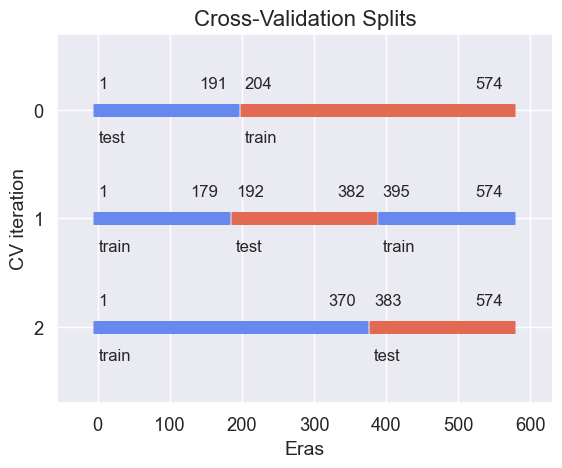

In [12]:
utils.plot_cv_split(
    cv_splits=cv_splits_get_ts,
    always_show_bin_ends=True,
    bin_end_offset=50,
    title=(
        "Cross-Validation Splits\"
    )
);

### 2.2 PurgedTimeSeriesSplitGroups from [forums](https://forum.numer.ai/t/era-wise-time-series-cross-validation/791/24?u=visp) 

NOTE: this yields index of the original dataframe/dataset passed in and not the eras in train and test.

In [17]:
from sklearn.model_selection._split import _BaseKFold, indexable, _num_samples


def purged_ts_split(n_splits, purge_groups, X, y=None, groups=None):
    X, y, groups = indexable(X, y, groups)
    n_samples = _num_samples(X)
    n_folds = n_splits + 1
    group_list = np.unique(groups)
    n_groups = len(group_list)
    if n_folds + purge_groups > n_groups:
        raise ValueError((f"Cannot have number of folds plus purged groups "
                          f"={n_folds+purge_groups} greater than the "
                          f"number of groups: {n_groups}."))
    indices = np.arange(n_samples)
    test_size = ((n_groups-purge_groups) // n_folds)
    test_starts = [n_groups-test_size*c for c in range(n_folds-1, 0, -1)]
    for test_start in test_starts:
        yield (indices[groups.isin(group_list[:test_start-purge_groups])],
               indices[groups.isin(group_list[test_start:test_start + test_size])])

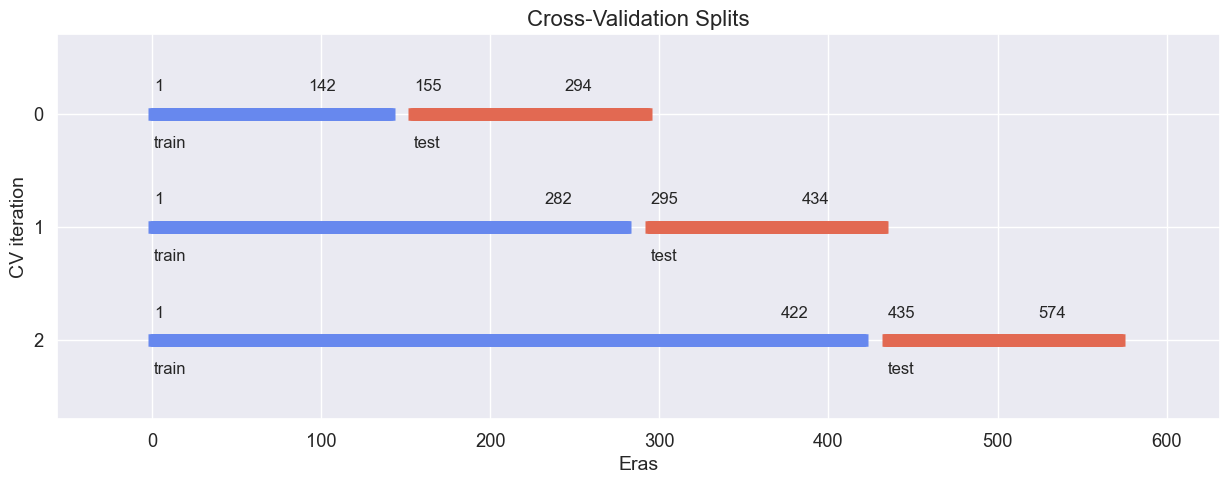

In [22]:
cv_splits_purged_ts = []
for train_ix, test_ix in purged_ts_split(n_splits=3, purge_groups=12, X=df, y=None, groups=df.era):
    df_train, df_test = df.iloc[train_ix], df.iloc[test_ix]
    cv_splits_purged_ts.append(
        {
            "train": df_train.era.unique(),
            "test": df_test.era.unique(),
        }
    )

_, ax = plt.subplots(1,1, figsize=(15, 5))
utils.plot_cv_split(
    cv_splits=cv_splits_purged_ts, always_show_bin_ends=True, bin_end_offset=50, ax=ax);